# spinal_test5.ipynb

This is a version of `spinal_test4` where the `am_pm_oscillator` units are replaced with an E-I pair of sigmoidals, and a sigmoidal alpha motoneuron.

# PART 1
Muscle lengths control without learning.

Here are some weights for the M-CE, M-CI, and A-M connections that I'd ideally would like to see develop in PART 2.
* When M and SPF have 6 units each, and SPF has SP-SF:

    MX to CEY
        0. iff X=Y, 
        0. if Y is agonist, 
        0. if partial agonist, 
        0.3 if partial antagonist, 
        1. if antagonist.
        
    MX to CIY
        1. iff X=Y, 
        0.3 if Y is agonist, 
        0.1 if partial agonist, 
        0. if partial antagonist, 
        0. if antagonist.   

    AX to MY
        (0., -0.4, 0.4) if X corresponds to Y
        (0, -0.2, 0.2) if X corresponds to an agonist of Y
        (0., 0., 0.) if X corresponds to a partial agonist of Y
        (0., 0.2, -0.2) if X corresponds to a partial antagonist of Y
        (0., 0.4, -0.4) if X corresponds to an antagonist of Y


In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
##################################
####### Create the network #######
##################################

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {'type' : plant_models.bouncy_planar_arm,
            'mass1' : 0.5,
            'mass2' : 0.5,
            'p1' : (-0.01, 0.04),
            'init_q1' : np.pi/4.,
            'init_q2' : np.pi/2.,
            'init_q1p' : 0.,
            'init_q2p' : 0.,
            'g' : 0.,
            'mu1' : .1,
            'mu2' : .1,
            'l_torque' : 0.01,
            'l_visco' : 0.05,
            'm_gain' : 5.,
            'l_gain' : 2.,
            'v_gain' : 5.,
            'spring' : 2.,
            'tau' : 0.01 } # ficticious time constant used in create_freqs_steps
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

# PARAMETER DICTIONARIES
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))

SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.6 * randz6(),
             'slope' : 4. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.03 * randz6() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda t: None }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz6(),
              'slope' : 5. * randz6(),
              'init_val' : 0.3 * randz6(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz6() }
M_params = {'type' : unit_types.out_norm_am_sig,
            'thresh' : 0. * randz6(),
            'slope' : 3. * randz6(),
            'init_val' : 0.2 * randz6(),
            'delay' : 0.2,
            'tau_fast': 0.01,
            'tau_mid': 0.05,
            'tau_slow' : 2.,
            'tau' : 0.01 * randz6(),
            'des_out_w_abs_sum' : 1. }
CE_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.2 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6() }
CI_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.2 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6() }
AL_parmas = {'type' : unit_types.sigmoidal,
             'thresh' : 0.3 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.02 * randz6() }
AF_params = {'type' : unit_types.logarithmic,
             'init_val' : 0.,
             'tau' : 0.02 * randz18(),
             'tau_fast': 0.005,
             'thresh' : [0., -0.1, 0.1]*6 } # length afferents report l/l0
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

# CONNECTION DICTIONARIES

# SF, SP to SPF
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }

# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }
# motor to spinal connections
# creating a test matrix
M_CE = np.zeros((6, 6))
M_CI = np.zeros((6, 6))
for x in range(6):
    M_CI[x,x] = 1.
    for pair in antagonists:
        if x == pair[0]:
            M_CE[x, pair[1]] = 1.
            M_CE[pair[1], x] = 1.
    for pair in part_antag:
        if x == pair[0]:
            M_CE[x, pair[1]] = 0.3
            M_CE[pair[1], x] = 0.3
    for pair in synergists:
        if x == pair[0]:
            M_CI[x, pair[1]] = 0.3
            M_CI[pair[1], x] = 0.3
    for pair in part_syne:
        if x == pair[0]:
            M_CI[x, pair[1]] = 0.1
            M_CI[pair[1], x] = 0.1
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : synapse_types.static,
            'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.static,
            'init_w' : M_CI.flatten() }
#M__C_syn = {'type' : synapse_types.rga,
#            'lrate': 0., #40.,
#            'inp_ports': 0,
#            'init_w' : M_C.flatten() } #{'distribution':'uniform', 'low':0.05, 'high':.1} }
# interneurons to alpha motoneurons
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' synapse_types.static,
              'init_w' : 1. }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' synapse_types.static,
              'init_w' : -1. }

# alpha motoneurons to plant
AL__P_conn = {'inp_ports' : list(range(0,18,3)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1.5 } #1.5 }
# afferents to motor
## Creating a test matrix
AF_M = np.zeros((6, 18))
def a_m_connect(A_M, pair_list, weights):
    for pair in pair_list:
        A_M[pair[0], 3*pair[1]] = weights[0]
        A_M[pair[0], 3*pair[1]+1] = weights[1]
        A_M[pair[0], 3*pair[1]+2] = weights[2]
        A_M[pair[1], 3*pair[0]] = weights[0]
        A_M[pair[1], 3*pair[0]+1] = weights[1]
        A_M[pair[1], 3*pair[0]+2] = weights[2]        
a_m_connect(AF_M, self_conn, (0., -0.4, 0.4))
a_m_connect(AF_M, synergists, (0., -0.2, 0.2))
a_m_connect(AF_M, part_syne, (0., 0., 0.))
a_m_connect(AF_M, part_antag, (0., 0.2, -0.2))
a_m_connect(AF_M, antagonists, (0.2, 0.4, -0.4))
AF_M = AF_M.transpose()
AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.static, #inp_sel, #synapse_types.inp_corr,
            'aff_port' : 0,
            'error_port' : 1,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 20.,
            'init_w' : A_M.flatten() } #.1 }
# length afferents to sensory
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : 2. }
# plant to sensory
"""
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
"""
# plant to afferents
bool_aff = [False] * 4 + [False, True, True, True] * 6
idx_aff = np.arange(28)[bool_aff] # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
P__AF_syn = {'type' : synapse_types.static,
            'init_w' : [2., 2., 1.]*6 }
# lateral connections in C
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = 
CI__CE_syn = 
"""
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.corr_inh,
                  'inp_ports': 1,
                  'init_w' : -1.,
                  'lrate' : 0.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.corr_inh,
                  'inp_ports': 1,
                  'init_w' : -.4,
                  'lrate' : 0.,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'init_w' : .8 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'init_w' : 0.4 }
"""
def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays as number of steps. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pa_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    D = [C__P_conn['delays'], np.mean(P__A_conn['delays']),
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pa_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

# CREATING UNITS
SF = net.create(6, SF_params)
SP = net.create(6, SP_params)
SPF = net.create(6, SPF_params)
M = net.create(6, M_params)
AL = net.create(6, AL_params)
AF = net.create(18, AF_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
"""
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(6, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(6, C_params)
"""
# SET THE PATTERNS IN SP
t_pres = 60. # number of seconds to hold each set of target lengths
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.4], 
               [0.35, 0.35],
               [0.4, 0.3],
               [0.35, 0.25],
               [0.3, 0.2],
               [0.25, 0.25],
               [0.2, 0.3],
               [0.25, 0.35]]
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
# normalize the lengths between min_len and max_len
min_len = 0.05
max_len = 0.95
m_lengths = np.array(m_lengths)
col_maxs = np.amax(m_lengths, axis=0)
col_mins = np.amin(m_lengths, axis=0)
m_lengths = np.minimum(np.maximum((m_lengths - col_mins) / (col_maxs-col_mins), min_len), max_len)

m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths

def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: m_lengths[m_idxs[int(np.floor(t/t_pres))]][idx]

for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_C0_track = net.create(len(M), track_params) # to track weights from M to C0
A_M0_track = net.create(18, track_params) # to track weights from A to M0
xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of C0
sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
spj_track = net.create(1, track_params) # input derivative for MX--C0
ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

# CONNECTING
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.set_plant_inputs(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.set_plant_inputs(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF, P__AF_conn, P__AF_syn)
# from AF to SF. Only the length afferents are selected
AF_len = [AF[i] for i in range(0,18,3)]
net.connect(AF_len, SF, AF__SF_conn, AF__SF_syn)
# from AF to M
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from SF, SP to SPF
#net.connect(SF, SPF[0:6], SFe__SPF_conn, SFe__SPF_syn)
net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn) 
#net.connect(SP, SPF[0:6], SPi__SPF_conn, SPi__SPF_syn)
net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after A-->M
# intraspinal connections
# from CE to CI
"""
syn_dicts = [C__C_syn_antag, C__C_syn_p_antag, C__C_syn_syne, C__C_syn_p_syne]
pair_lists = [antagonists, part_antag, synergists, part_syne] # order should match list above
for pair_list, syn_dict in zip(pair_lists, syn_dicts):
    firsts = [C[p[0]] for p in pair_list]
    seconds = [C[p[1]] for p in pair_list]
    net.connect(firsts, seconds, C__C_conn, syn_dict)
    net.connect(seconds, firsts, C__C_conn, syn_dict)

"""

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_C0_fun(idx):
    """ Creates a function to track a weight from M to C0. """
    return lambda t: net.syns[C[0]][idx].w
for idx in range(len(M)):
    net.units[M_C0_track[idx]].set_function(M_C0_fun(idx))
# This assumes the first connections to M are A-->M    
def A_M0_fun(idx):
    """ Creates a function to track a weight from A to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(18):
    net.units[A_M0_track[idx]].set_function(A_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->C0
X = 0 # index of the M unit we'll monitor
net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
po_de = net.units[C[0]].custom_inp_del
net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
                                    net.units[C[0]].get_lpf_mid(po_de))
net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
ds = net.syns[C[0]][0].delay_steps
net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                     net.units[M[X]].get_lpf_mid(ds))

# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [3]:
start_time = time.time()
times, data, plant_data  = net.flat_run(30.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 24.889853477478027 seconds


[0.09622551 0.01641915 0.36872773 0.07426753 0.07887448 0.08803156]
[0.13169847 0.02552673 0.0924293  0.0682045  0.06984557 0.06848936]


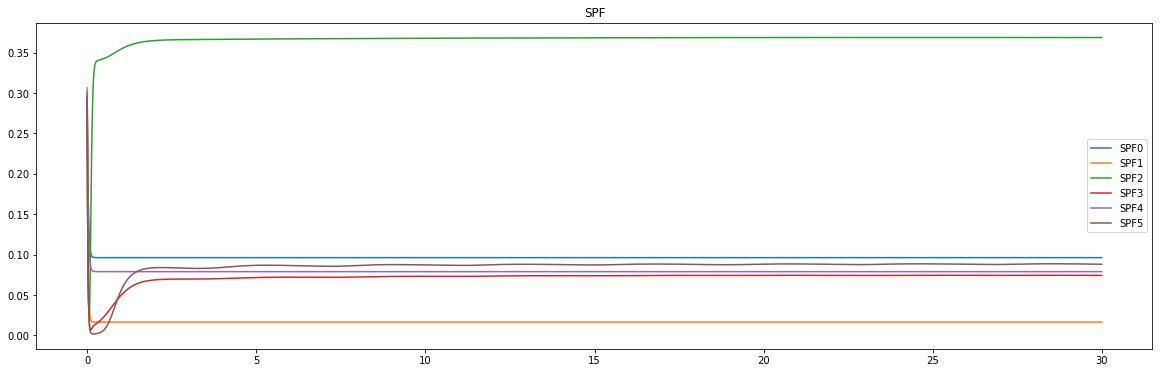

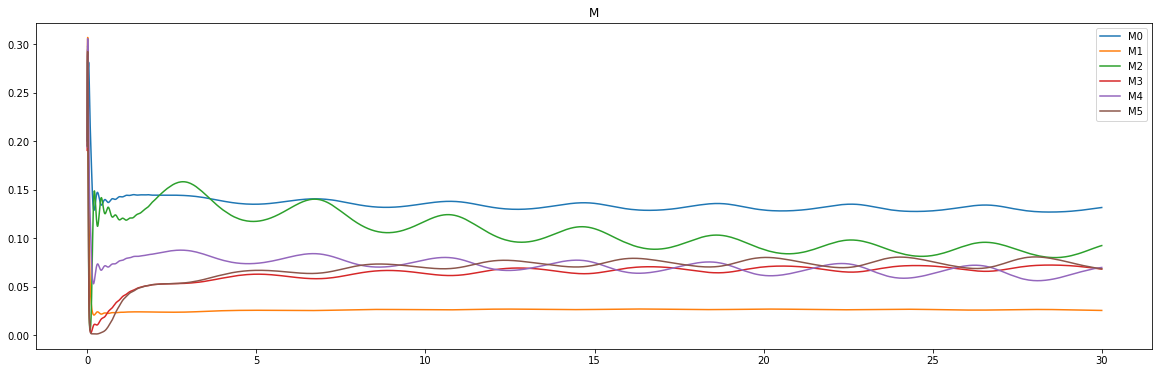

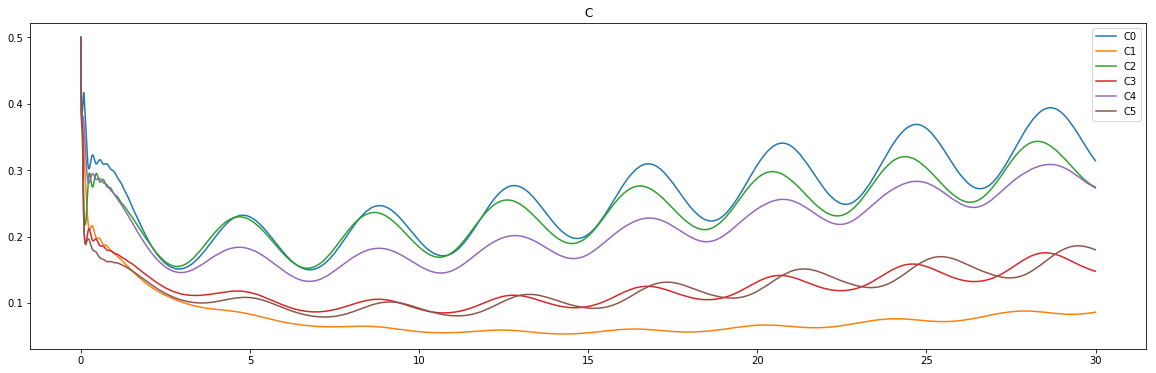

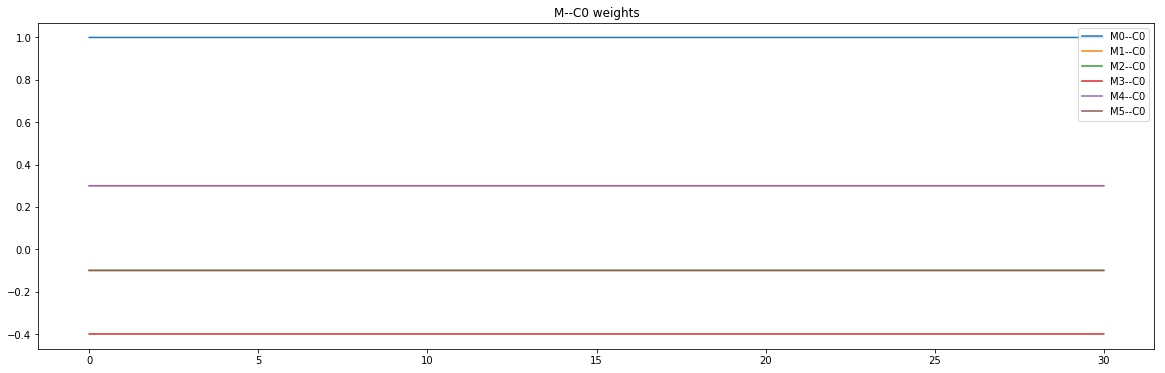

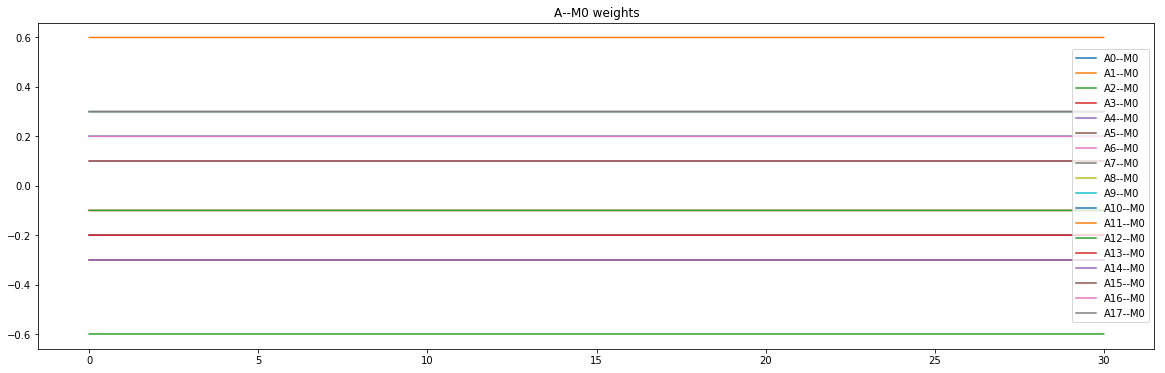

In [4]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
C_data = np.array(data[C])
plt.plot(times, C_data.transpose())
C_legends = ['C'+str(i) for i in range(len(C))]
plt.legend(C_legends)
plt.title('C')

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
M_C0_legends = ['M'+str(i)+'--C0' for i in range(len(M_C0_track))]
plt.legend(M_C0_legends)
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
A_M0_legends = ['A'+str(i)+'--M0' for i in range(len(A_M0_track))]
plt.legend(A_M0_legends)
plt.title('A--M0 weights')

plt.show()

A_data:
[0.00000000e+000 9.69049251e-002 1.18690261e+000 0.00000000e+000
 9.65284068e-002 4.33235802e-001 9.35689202e-001 9.58189559e-002
 1.11323853e+000 6.23491022e-001 9.29488383e-002 7.61767699e-001
 9.88131292e-323 9.70315642e-002 1.08379393e+000 6.75255601e-001
 9.25173325e-002 8.34810118e-001]


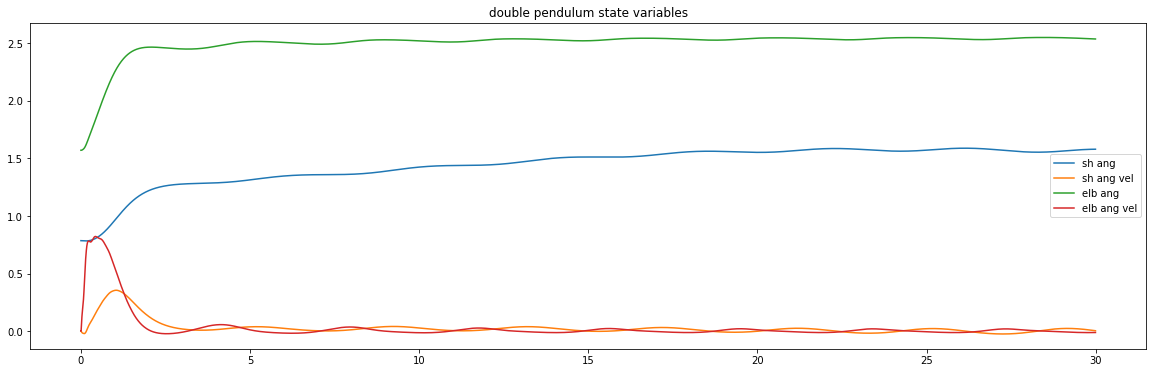

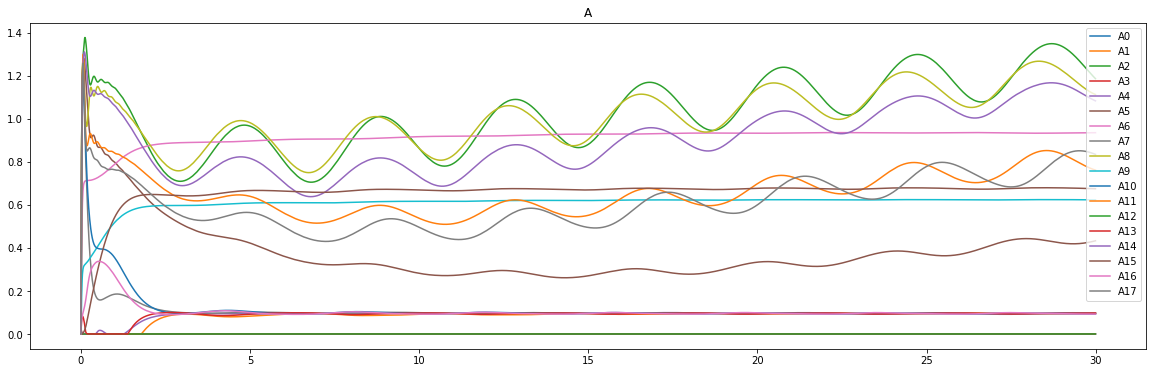

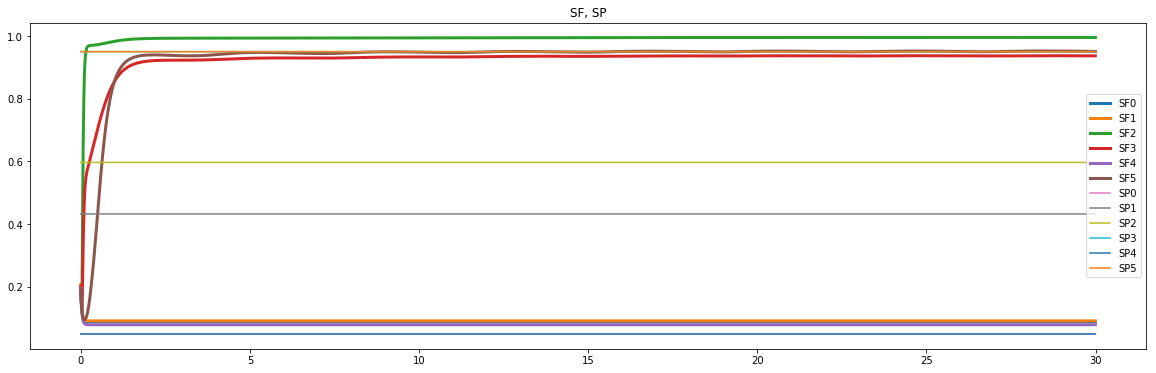

SF = 
[0.08863108 0.09175256 0.99516351 0.93651439 0.07944648 0.95056836]
SP = 
[0.05       0.43256148 0.5968367  0.95       0.05       0.95      ]


In [5]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4]
plt.plot(times, P_state)
plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.title('double pendulum state variables')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
A_legends = ['A'+str(i) for i in range(len(A))]
plt.legend(A_legends)
plt.title('A')
print('A_data:')
print(A_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=3)
plt.plot(times, SP_data.transpose())
plt.legend(A_legends)
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


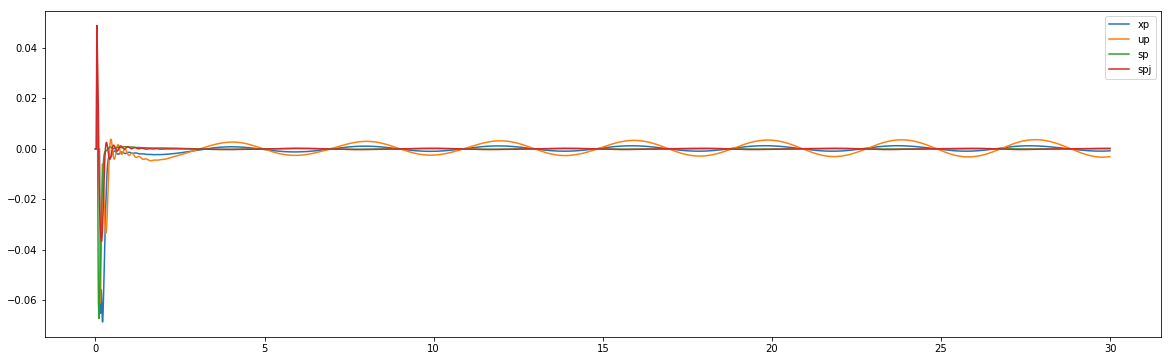

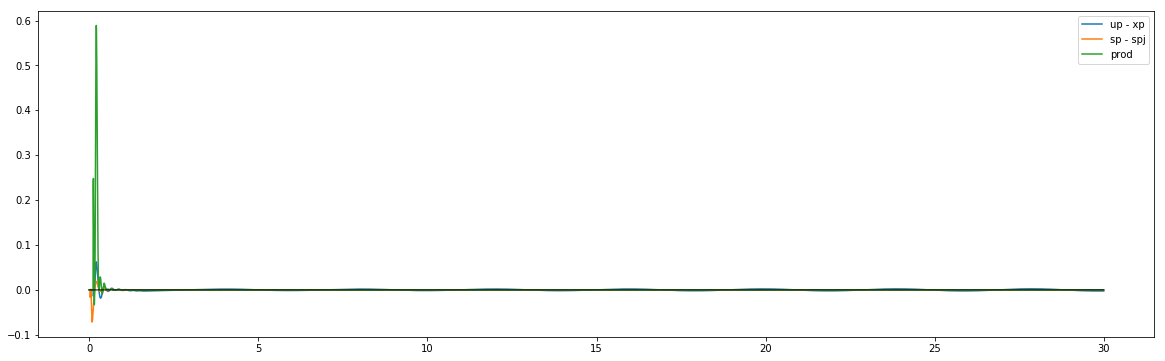

In [6]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

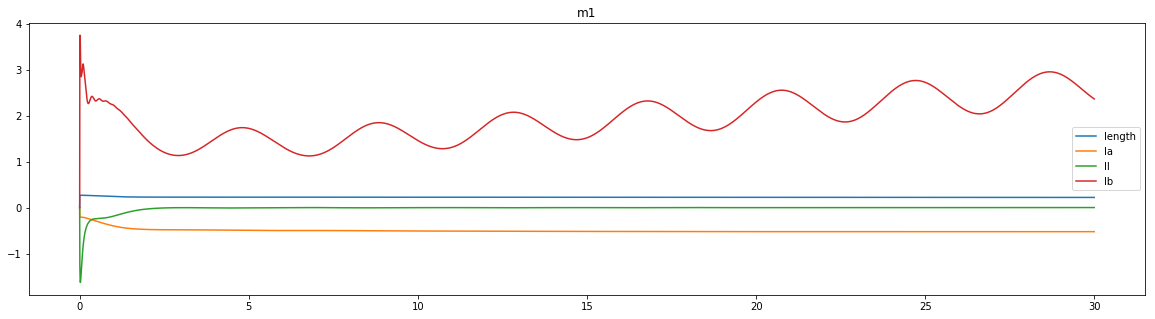

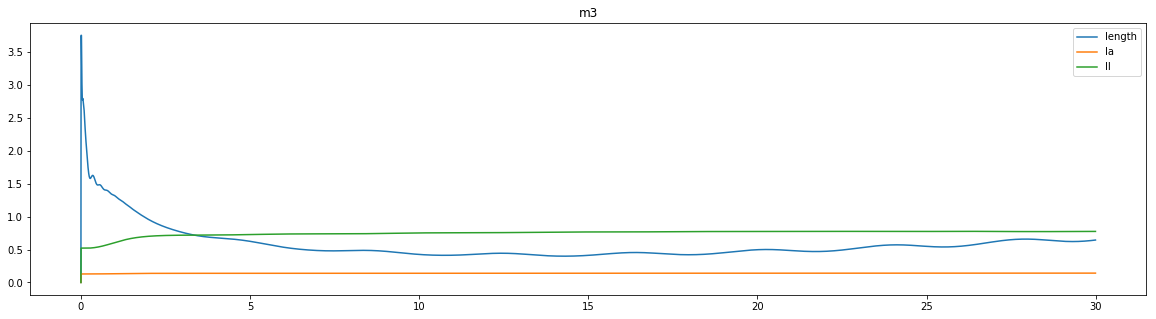

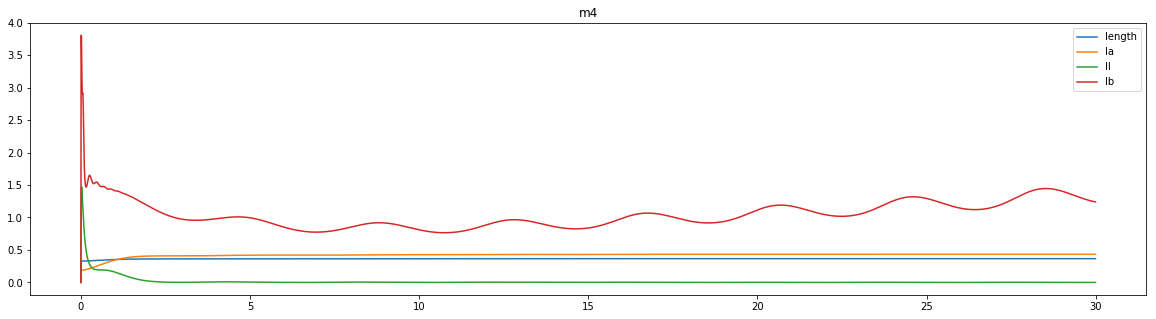

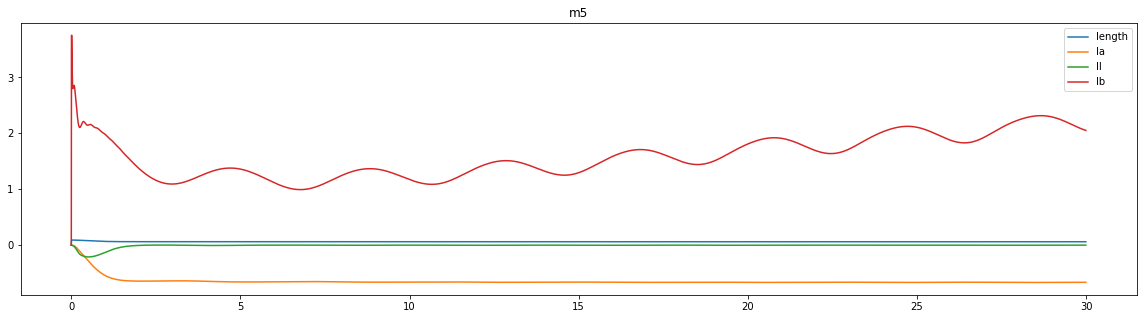

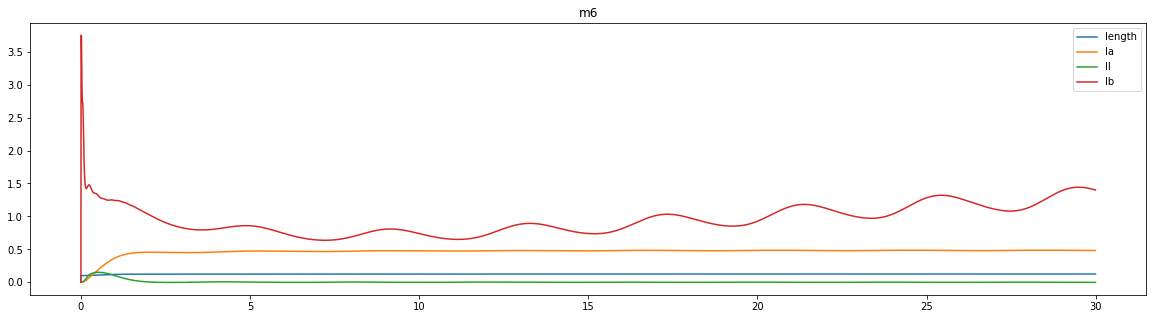

In [7]:
# plotting muscle outputs
fs = (20,5)
legs = ['length', 'Ia', 'II', 'Ib']
m1_fig = plt.figure(figsize=fs)
m1_affs = arm_activs[:,4:8]
plt.plot(times, m1_affs)
plt.legend(legs)
plt.title('m1')

m3_affs = arm_activs[:,11:14]
m3_fig = plt.figure(figsize=fs)
plt.plot(times, m3_affs)
plt.legend(legs)
plt.title('m3')


m4_fig = plt.figure(figsize=fs)
m4_affs = arm_activs[:,16:20]
plt.plot(times, m4_affs)
plt.legend(legs)
plt.title('m4')

m5_fig = plt.figure(figsize=fs)
m5_affs = arm_activs[:,20:24]
plt.plot(times, m5_affs)
plt.legend(legs)
plt.title('m5')

m6_fig = plt.figure(figsize=fs)
m6_affs = arm_activs[:,24:28]
plt.plot(times, m6_affs)
plt.legend(legs)
plt.title('m6')

plt.show()

In [8]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) A (24) --> M, w=-0.200000, port=0, plant_out=None
1) A (25) --> M, w=-0.300000, port=0, plant_out=None
2) A (26) --> M, w=-0.600000, port=0, plant_out=None
3) A (27) --> M, w=-0.100000, port=0, plant_out=None
4) A (28) --> M, w=-0.200000, port=0, plant_out=None
5) A (29) --> M, w=-0.300000, port=0, plant_out=None
6) A (30) --> M, w=0.100000, port=0, plant_out=None
7) A (31) --> M, w=0.200000, port=0, plant_out=None
8) A (32) --> M, w=0.300000, port=0, plant_out=None
9) A (33) --> M, w=0.200000, port=0, plant_out=None
10) A (34) --> M, w=0.300000, port=0, plant_out=None
11) A (35) --> M, w=0.600000, port=0, plant_out=None
12) A (36) --> M, w=-0.100000, port=0, plant_out=None
13) A (37) --> M, w=-0.200000, port=0, plant_out=None
14) A (38) --> M, w=-0.300000, port=0, plant_out=None
15) A (39) --> M, w=0.100000, port=0, plant_out=None
16) A (40) --> M, w=0.200000, port=0, plant_out=None
17) A (41) --> M, w=0.300000, port=0, plant_out=None
18) SPF (12) --> M, 

---

In [9]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(10,10))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, muls_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 4), init_func=init, blit=True, interval=10)

plt.show()

FigureCanvasNbAgg()

In [10]:
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(7, 28, 4))]
ten.shape

(4000, 6)

In [11]:
ipx.shape

(12, 4000)